Итоговая работа
=====================

Поздравляю вас, теперь вы вооружены знаниями по предобработке данных, и пора применить их на интересном кейсе.

Представлены данные такси, по которым мы должны предсказать возьмёт ли таксист заказ или нет(driver_response).

Принципы вы знаете, чек-лист аналогичен лабораторной работе.

Чек-лист:
1. Загрузите датасет taxi.csv.
2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.
4. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost

Если возникнут затруднения, то смотрите на материал практических занятий. Данного там должно хватить для выполнения всех пунктов. Желаю успеха!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from math import sqrt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas_profiling
from sklearn import preprocessing

from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('taxi.csv')
list_c = data.columns
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [35]:
data.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.662189e+05,3.159860,13.827790,3446.376360,460867.01291,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,3.259360e+05,2.054222,7.306496,2038.738677,266064.98953,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,4.000000e+00,0.000000,0.000000,14.000000,18.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.855552e+05,1.000000,8.000000,1421.000000,229178.50000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,5.656715e+05,3.000000,16.000000,3506.500000,462420.00000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,8.487198e+05,5.000000,20.000000,5242.000000,690894.00000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.00000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


offer_gk	driver_gk order_gk -колонки которые решаем удалить, так как это ид заказа, водителя и заказчика уникальные

In [13]:
data_t = data.drop(['offer_gk',	'driver_gk', 'order_gk'], axis = 1)

Это категориальные данные которые нужно будет кодировать

In [43]:
Видим значительное количество данных с расстоянием -1. Попробуем понять, что с этим данными ...

(99897, 11)

In [45]:
data_ = data_t.loc[data_t['distance_km'] == -1]

In [47]:
data_.shape

(26207, 11)

In [5]:
#таким образом мы оставили все строки где можем рассчитать расстояние по данным широты и долготы
def conv_la(row):
    #print(row)
    if row['distance_km'] == -1: 
        row['distance_km'] = 0
        # print(row['distance_km'])
    return row    
        

In [14]:
data_t = data_t.apply(conv_la, axis = 1)

In [15]:
data_t.loc[data_t['distance_km'] > 400 ].shape

(46, 11)

In [ ]:
Удалим строки, где расстояние получилось более 400 км как выпады, это за пределами 6 сигм

In [16]:
data_t = data_t.drop(data_t.loc[data_t['distance_km'] > 400].index)

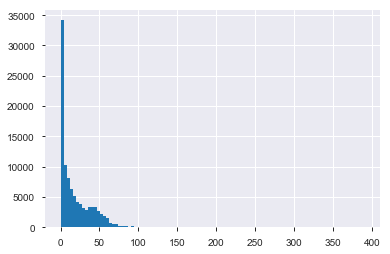

In [9]:
data_t['distance_km'].hist(bins = 100)

In [17]:
data_t = data_t.drop(['duration_min','driver_latitude',	'driver_longitude', 'origin_order_latitude','origin_order_longitude'], axis = 1)

In [18]:
data_t.head()

,weekday_key,hour_key,distance_km,offer_class_group,ride_type_desc,driver_response
0,5,20,0.000,Economy,private,0
1,5,14,18.802,Standard,private,1
2,6,14,6.747,Economy,private,0
3,2,6,0.000,Economy,private,1
4,4,16,12.383,Economy,private,1


In [19]:
#Функция переводит категорийные значения в набор колонок с 0,1
def oh_encoder(df, list_col):
  
  r_df = df.copy()

  for col in list_col:
    conv = df[col].get_values().reshape(-1, 1)

    # One-hot encoding
    oh_encoder = preprocessing.OneHotEncoder()
    oh_encoder.fit(conv)
    oh_result = oh_encoder.transform(conv).toarray()

    conv_columns = ['{}_{}'.format(col,i) for i in range(oh_result.shape[1])]
    conv_df = pd.DataFrame(oh_result, columns=conv_columns)
    conv_df.index = df.index
    r_df = pd.concat([r_df, conv_df], axis=1)
    r_df = r_df.drop([col], axis=1)

  return r_df 

In [20]:
# колонки которые будем переводить в категорийные через OneHotEncording
list_col = 'weekday_key', 'hour_key', 'offer_class_group', 'ride_type_desc'
data_t['weekday_key'] =  data_t['weekday_key'].astype(str)
data_t['hour_key'] =  data_t['hour_key'].astype(str)
#data_t['driver_response'] =  data_t['driver_response'].astype(str)


In [21]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99954 entries, 0 to 99999
Data columns (total 6 columns):
weekday_key          99954 non-null object
hour_key             99954 non-null object
distance_km          99954 non-null float64
offer_class_group    99954 non-null object
ride_type_desc       99954 non-null object
driver_response      99954 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 5.3+ MB


In [22]:
data_n = oh_encoder(data_t, list_col)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

In [24]:
data_n = data_n.drop_duplicates()

In [25]:
data_n.shape

(60621, 46)

In [ ]:
убирается 40 тыс строк дубликатов !!!

In [ ]:
Теперь можно проводить обучение

In [26]:
list_res = ['driver_response']
train_X = data_n.drop(list_res, axis = 1)
train_Y = data_n[list_res]

X_train,X_test,y_train,y_test = train_test_split(train_X,
                                                 train_Y,
                                                 test_size = 0.2,#%80 train, 20% test
                                                 random_state = 3)

In [27]:
from sklearn.ensemble import RandomForestClassifier
# создаем модель деревья решений
model=RandomForestClassifier(n_estimators=100)

#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import accuracy_score 
#model = LogisticRegression()
model.fit(X_train, y_train)
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test,predicted_classes)
print('Точность предсказания модели: ', accuracy)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Точность предсказания модели:  0.5451546391752577


In [28]:
list_res = ['driver_response']
train_X = data_n.drop(list_res, axis = 1)
train_Y = data_n[list_res]

X_train,X_test,y_train,y_test = train_test_split(train_X,
                                                 train_Y,
                                                 test_size = 0.2,#%80 train, 20% test
                                                 random_state = 3)

In [29]:
import xgboost

model=xgboost.XGBClassifier()

model.fit(X_train, y_train)
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test , predicted_classes)
print('Точность предсказания модели: ', accuracy)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Точность предсказания модели:  0.6520412371134021
